## Lesson 2 — Building a Simple Model

**Learning objectives**
- Split the data into training and test sets.
- Train a simple classifier (Logistic Regression) and an alternative model (Decision Tree).
- Evaluate the model using accuracy, confusion matrix, and classification report.
- Inspect basic model explanations (coefficients / feature importances).
- Understand what accuracy means and its limitations.

**Notes for beginners**
- IMPORTANT: We must **not** use the final grade `G3` as a feature because `passed` is derived from `G3`. Using `G3` would leak the answer into the model (data leakage).


In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

df = pd.read_csv("student_exam.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (50, 10)
   student_id sex  age  studytime  failures  absences  G1  G2  G3  passed
0           1   M   17          4         0         1  10  11  14       1
1           2   F   16          2         1         4  17  19  16       1
2           3   M   17          3         2         4  11  10   9       0
3           4   M   18          3         1         1   8  10  12       1
4           5   M   17          2         3         2   7   7   8       0


### Feature selection (avoid leakage)
We will build models using features that are available *before* knowing the final grade:
- Keep: `sex`, `studytime`, `failures`, `absences`, `G1`, `G2`
- Drop: `G3` and any ID columns (e.g., `student_id`) because `G3` determines `passed` and using it causes leakage.


In [3]:
X = df[['sex', 'studytime', 'failures', 'absences', 'G1', 'G2']]  # features
y = df['passed']  # target (0=failed, 1=passed)

# Convert categorical 'sex' into numeric dummy (female=1 if drop_first=True)
X = pd.get_dummies(X, columns=['sex'], drop_first=True)

print("Feature columns after encoding:", X.columns.tolist())
print("Target distribution:\n", y.value_counts())


Feature columns after encoding: ['studytime', 'failures', 'absences', 'G1', 'G2', 'sex_M']
Target distribution:
 passed
1    28
0    22
Name: count, dtype: int64


### Train/Test split
- We will split the data into training and test sets.
- Use `stratify=y` to preserve the class proportions in both sets (important for small datasets).
- Use `random_state` for reproducibility.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())


Train shape: (40, 6) Test shape: (10, 6)
Train class distribution:
 passed
1    22
0    18
Name: count, dtype: int64
Test class distribution:
 passed
1    6
0    4
Name: count, dtype: int64


### Feature scaling
- Logistic Regression benefits from scaling numeric features, Decision Tree does not require it.
- We'll scale numeric columns only and keep `sex` dummy as-is.


In [6]:
numeric_cols = ['studytime','failures','absences','G1','G2']

# StandardScaler: fit on training data only
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# Ready-to-use X for models
X_train_proc = X_train_scaled
X_test_proc  = X_test_scaled


### Train Logistic Regression
- We'll use `liblinear` solver (good for small datasets).
- After training, we compute accuracy, confusion matrix and classification report.


In [7]:
# Train Logistic Regression
log_clf = LogisticRegression(solver='liblinear', random_state=42)
log_clf.fit(X_train_proc, y_train)

# Predict on test set
y_pred_log = log_clf.predict(X_test_proc)

# Evaluate
acc_log = accuracy_score(y_test, y_pred_log)
cm_log = confusion_matrix(y_test, y_pred_log)
report_log = classification_report(y_test, y_pred_log, digits=3)

print("Logistic Regression accuracy:", acc_log)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm_log)
print("\nClassification Report:\n", report_log)


Logistic Regression accuracy: 0.9

Confusion Matrix (rows=true, cols=pred):
 [[3 1]
 [0 6]]

Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.750     0.857         4
           1      0.857     1.000     0.923         6

    accuracy                          0.900        10
   macro avg      0.929     0.875     0.890        10
weighted avg      0.914     0.900     0.897        10



### Logistic Regression coefficients
- Coefficients show the direction (+/-) and relative magnitude of each feature.
- Larger absolute value = stronger effect on the log-odds of passing.
- We will pair each coefficient with its feature name and sort by absolute magnitude.


In [10]:
# Coefficients with feature names
coef_df = pd.DataFrame({'feature': X_train_proc.columns,'coef': log_clf.coef_[0]})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print(coef_df)


     feature      coef  abs_coef
0         G2  1.425143  1.425143
1         G1  0.851240  0.851240
2  studytime  0.716829  0.716829
3   absences -0.332041  0.332041
4   failures -0.212899  0.212899
5      sex_M -0.134782  0.134782


### Decision Tree as an alternative
- Decision Trees don't need scaling and can capture non-linear relationships.
- We will train a small tree (e.g., max_depth=3) to avoid overfitting on a small dataset.


In [11]:
# Train Decision Tree (we can use the original unscaled data or scaled; tree ignores scale)
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)  # note: using X_train (unscaled) is OK for trees

# Predict and evaluate
y_pred_tree = tree_clf.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree)
report_tree = classification_report(y_test, y_pred_tree, digits=3)

print("Decision Tree accuracy:", acc_tree)
print("\nDecision Tree Confusion Matrix:\n", cm_tree)
print("\nDecision Tree Classification Report:\n", report_tree)

# Feature importances
feat_imp = pd.DataFrame({'feature': X_train.columns,'importance': tree_clf.feature_importances_
                         }).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nDecision Tree feature importances:\n", feat_imp)


Decision Tree accuracy: 0.8

Decision Tree Confusion Matrix:
 [[3 1]
 [1 5]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0      0.750     0.750     0.750         4
           1      0.833     0.833     0.833         6

    accuracy                          0.800        10
   macro avg      0.792     0.792     0.792        10
weighted avg      0.800     0.800     0.800        10


Decision Tree feature importances:
      feature  importance
0         G2    0.553593
1         G1    0.259930
2      sex_M    0.085624
3  studytime    0.054338
4   absences    0.046514
5   failures    0.000000


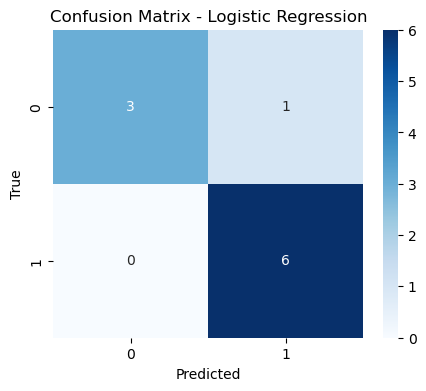

In [12]:
# Plot confusion matrix for logistic regression
plt.figure(figsize=(5,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


### Quick cross-validation (stretch)
- Cross-validation gives a more robust estimate of model performance.
- Use stratified folds for classification.
- With small datasets use e.g. 5 folds, but be careful: too many folds -> small validation folds.


In [13]:
# Cross-validate Logistic Regression (on pre-processed features)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_log = cross_val_score(log_clf, X_train_proc, y_train, cv=cv, scoring='accuracy')

print("Logistic CV scores (accuracy) on training set:", cv_scores_log)
print("Mean CV accuracy: {:.3f} ± {:.3f}".format(cv_scores_log.mean(), cv_scores_log.std()))


Logistic CV scores (accuracy) on training set: [0.75  0.875 1.    0.75  0.75 ]
Mean CV accuracy: 0.825 ± 0.100


### What does "accuracy" mean?
- **Accuracy** = (number of correct predictions) / (total predictions).
  - Example: accuracy = 0.80 => 80% of test examples were classified correctly.
- **Limitation of accuracy**:
  - If classes are imbalanced (e.g., 90% pass, 10% fail), a dumb model that always predicts "pass" gets 90% accuracy but is useless for finding at-risk students.
  - That's why we also look at **confusion matrix**, **precision**, **recall**, and **F1-score**.

**Confusion matrix (binary)**:
- Rows = true labels, Columns = predicted labels.
- For `passed` (1) vs `failed` (0), typical order is:
  - `[[TN, FP],
     [FN, TP]]`
- **Precision** (for class=1) = TP / (TP + FP) -> when the model says "will pass", how often is it correct.
- **Recall** (for class=1) = TP / (TP + FN) -> of all actual passers, how many did the model find.
- **If our goal is to identify students at risk of failing**, we may prefer high **recall for the failed class** (i.e. we want to catch as many potential failures as possible), or tune thresholds accordingly.
